importing libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


Loading Data

In [3]:
file_path = r"C:\Users\User\Downloads\Anaconda\Bank Data\bank-full.csv"
df = pd.read_csv(file_path)
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Data Cleaning

In [4]:
# Check for missing values
print(df.isnull().sum())

# Check for unique values and data types
print(df.info())
print(df['y'].value_counts())


 age         0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0    age       45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 

Exploratory Data Analysis (EDA)

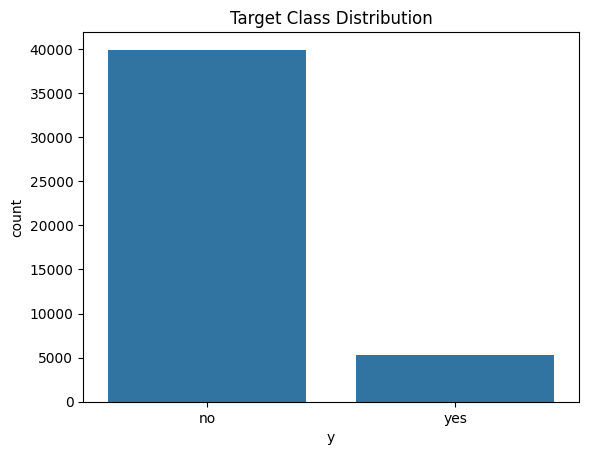

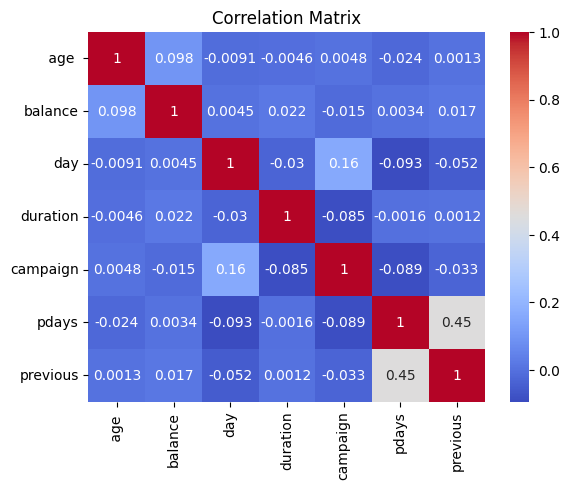

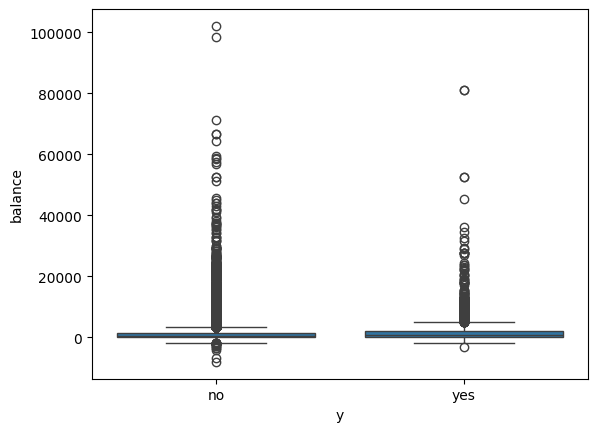

In [5]:
# Target distribution
sns.countplot(x='y', data=df)
plt.title("Target Class Distribution")
plt.show()

# Correlation heatmap for numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Boxplot: balance vs y
sns.boxplot(x='y', y='balance', data=df)
plt.show()


Feature Engineering

In [6]:
# Encode binary categorical variables
binary_cols = ['default', 'housing', 'loan', 'y']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Encode month as ordinal
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = df['month'].apply(lambda x: month_order.index(x))

# One-hot encode remaining categorical features
categorical_cols = ['job', 'marital', 'education', 'contact', 'poutcome']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Train/Test Split and Scaling

In [8]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                    param_grid=params, cv=3, scoring='f1')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [16]:

log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


Modeling

Logistic Regression

In [18]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

print("Logistic Regression:")
print(classification_report(y_test, log_preds))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.64      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



Random Forset

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, rf_preds))


Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.67      0.38      0.48      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.68      0.72      9043
weighted avg       0.89      0.91      0.89      9043



XGBoost

In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: y
0    31937
1     4231
Name: count, dtype: int64
After SMOTE: y
0    31937
1    31937
Name: count, dtype: int64


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_smote.fit(X_train_res, y_train_res)

xgb_preds_smote = xgb_model_smote.predict(X_test)

print("XGBoost with SMOTE:")
print(classification_report(y_test, xgb_preds_smote))


XGBoost with SMOTE:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7985
           1       0.54      0.59      0.57      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.76      0.75      9043
weighted avg       0.90      0.89      0.90      9043



In [24]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=params,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)
print("Best parameters found:", grid.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [25]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, xgb_preds))


XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7985
           1       0.63      0.48      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.72      0.74      9043
weighted avg       0.90      0.91      0.90      9043



Evaluation & Confusion Matrix

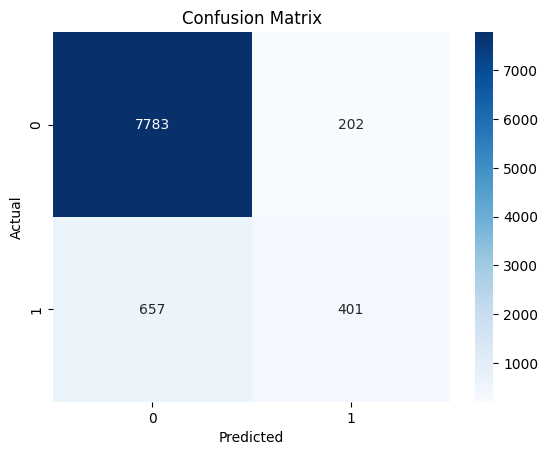

In [21]:
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
